## LeNet 网络结构

在LeNet中, 使用卷积层学习图片的空间特征; 使用全连接层转换到类别空间

In [1]:
import torch
from torch import nn


class Reshape(nn.Module):
    def forward(self, x):
        # 批量大小, 通道数量, 图像高, 宽
        return x.view(-1, 1, 28, 28)

net = nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

## 查看每一层的输入输出的变化

In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

for layer in net:
    X = layer(X)
    print(f'[{layer.__class__.__name__}] output shape is {X.shape}')

[Reshape] output shape is torch.Size([1, 1, 28, 28])
[Conv2d] output shape is torch.Size([1, 6, 28, 28])
[Sigmoid] output shape is torch.Size([1, 6, 28, 28])
[AvgPool2d] output shape is torch.Size([1, 6, 14, 14])
[Conv2d] output shape is torch.Size([1, 16, 10, 10])
[Sigmoid] output shape is torch.Size([1, 16, 10, 10])
[AvgPool2d] output shape is torch.Size([1, 16, 5, 5])
[Flatten] output shape is torch.Size([1, 400])
[Linear] output shape is torch.Size([1, 120])
[Sigmoid] output shape is torch.Size([1, 120])
[Linear] output shape is torch.Size([1, 84])
[Sigmoid] output shape is torch.Size([1, 84])
[Linear] output shape is torch.Size([1, 10])


## 加载 fashion mnist 数据集

In [3]:
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

## 衡量准确度

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            # d2l.accuracy(net(X), y) 计算正确预测的个数
            # y.numel() 返回张量中元素的个数
            metric.add(d2l.accuracy(net(X), y), y.numel())
    # 正确预测的个数 / 总数
    return metric[0] / metric[1]

## 训练函数

In [5]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
                
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

## 模型训练

loss 0.467, train acc 0.826, test acc 0.823
25980.1 examples/sec on mps


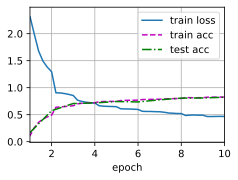

In [6]:
lr = 0.9
num_epochs = 10
device = torch.device('mps')

net.to(device)
train_ch6(net, train_iter, test_iter, num_epochs, lr, device)

## 查看样例

In [7]:
img = None

for X, y in train_iter:
    print(X.shape)
    x = X[0]
    print(x.shape)
    img = x[0]
    break

torch.Size([256, 1, 28, 28])
torch.Size([1, 28, 28])


In [8]:
img.shape

torch.Size([28, 28])

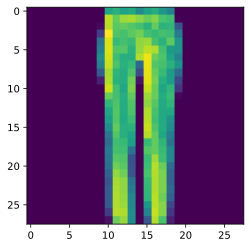

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

## Animator 使用方法

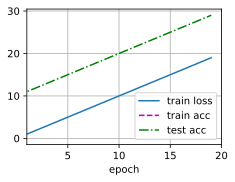

In [10]:
import time

animator = d2l.Animator(xlabel='epoch', xlim=[1, 20],
                        legend=['train loss', 'train acc', 'test acc'])

for i in range(20):
    # animator.add(横坐标, (曲线1纵坐标, 曲线2纵坐标, 曲线3纵坐标))
    animator.add(i, (i, None, i+10))
    time.sleep(1)